In [1]:
import warnings
warnings.filterwarnings('ignore')
from plotnine import *

from sklearn.decomposition import PCA
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler #Z-score variables
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split # simple TT split cv


import numpy as np

# 0. Together

Regularization is a way to adjust your *loss function* to reflect the belief that very small relationships (positive or negative) between variables are *probably* due to weird quirks of our particular sample, and don't apply to the population as a whole. Forcing these small relationships to be closer to zero (Ridge) or zero (LASSO) can help our model perform better on *other* samples of data, therefore helping to combat overfitting.

LASSO specifically is used as a method of **variable selection**, because reducing a variables coefficient to zero is essentially the same thing as *removing* it from the model. While in ML we often don't care about or use p-values, the Statistician part of me needs to tell you this: *if you use LASSO to choose the variables in your model, the p-values and confidence intervals are NO LONGER VALID.* If you want to use p-values and CIs still, you need to correct for the fact that you "cherry-picked" the best variables from the model. See [this paper](https://www.pnas.org/content/112/25/7629) if you're ever going to do this. PLEASE.

## Ridge
Ridge Regression adds an extra penalty to the typical regression loss function: the L2 Norm. L2 refers to the fact that we take every coefficient, square it (i.e. take it to the 2nd power), add them together, and take the square root. You might notice that the L2 norm is also how we calculate distances, which is why the `np.linalg.norm()` function has been helpful to calculate distances!

$$ L2 = \sqrt{\sum_{i = 1}^N X_N^2}$$

## LASSO
LASSO adds a *different* extra penalty to the typical regression loss function: the L1 Norm. L1 refers to the fact that we take every coefficient, take the absolute value, and add them together. 

$$ L1 = \sum_{i = 1}^N \lvert X_N\rvert $$


## How to choose between LASSO and Ridge?

In general: if you want to do variable selection (i.e. completely remove some variables), choose LASSO. But in the real world, people often use something called Elastic Net, which adds both LASSO (L1) *and* Ridge (L2) penalties to the loss function:

$$ ElasticNet = \alpha \sum_{i = 1}^N \lvert X_N\rvert + (1-\alpha)\sqrt{\sum_{i = 1}^N X_N^2} $$

# Hyperparameter Tuning + Regularization

The penalty terms (called `alpha` in LASSO and Ridge) have a huge impact on how much LASSO and Ridge drag coefficients towards (or to) zero. The bigger alpha, the bigger the penalty. So we often need to use hyperparameter tuning in order to choose `alpha`.

We can do this the exact same way we did with things like `max_depth` and `n_neighbors`.

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV


df = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/spotifypandas.csv")


# from All the Stuff You Need to Know (Python)
num = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

df_numeric = df.select_dtypes(include = num)

predictors = [x for x in df_numeric.columns if x != "tempo"]
continuous = [x for x in predictors if x != "mode"]


X = df_numeric[predictors]
y = df_numeric["tempo"]

# TTS
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

# pipeline

# print(pipe.get_params().keys())

# gridsearch
a = {"lasso__alpha": [0.0001, 0.001, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 2, 3, 5]}


# evaluate model
print("PENALTY:", grid.best_estimator_.get_params()["lasso__alpha"])
print("TRAIN:", r2_score(y_train, grid.predict(X_train)))
print("TEST :", r2_score(y_test, grid.predict(X_test)))


In [ ]:
# grab coefs


# 1. Comparing Coefficients of Regression, LASSO, and Ridge

The function `compare()` simulates a large dataset with 17 variables. 7 of those variables (the vowels, AEIOUYW) do have real relationships with the outcome, `X`. You can see the true coefficients in the part of the code that looks like this:

```
 # coefficients
    a = 8.23
    e = 3.48
    i = 2.97
    o = 5.12
    u = 7.83
    y = 12.34
    w = 1.38
    
```

10 of the variables (the consonants, BCDFGHJKLMN) do not have *any* relationship with `X` (i.e. their true coefficient is 0).


`compare()` then runs regular Regression (no penalty), Ridge Regression (L2 penalty) and LASSO (L1 penalty). 

In [26]:
def compare(n = 10000, alpha = 1):
    
    # Real Variables
    A = np.random.normal(0,1,n)
    E = np.random.normal(0,1,n)
    I = np.random.normal(0,1,n)
    O = np.random.normal(0,1,n)
    U = np.random.normal(0,1,n)
    Y = np.random.normal(0,1,n)
    W = np.random.normal(0,1,n)

    # Unrelated Variables
    B = np.random.normal(0,1,n)
    C = np.random.normal(0,1,n)
    D = np.random.normal(0,1,n)
    G = np.random.normal(0,1,n)
    H = np.random.normal(0,1,n)
    J = np.random.normal(0,1,n)
    K = np.random.normal(0,1,n)
    L = np.random.normal(0,1,n)
    
    
    # coefficients
    a = 12.34
    e = 8.23 
    i = 5.12
    o = 2.97 
    u = -1.38
    y = -3.48
    w = -7.83
    
    # Outcome
    X = 100 + A*a + E*e + I*i + O*o + U*u + Y*y + W*w + np.random.normal(0,15,n)
    
    
    X = (X - np.mean(X))/np.std(X) # z-score X
    # the other variables already have a mean of 0 and sd of 1
    

    # Data Frame
    df = pd.DataFrame({"A": A,"E": E, "I":I,"O":O,"U":U,
                       "B":B,"C":C,"D":D,"G":G,"H":H,"J":J,
                       "K":K,"L":L,"Y":Y,"W":W,
                       "X":X})

    feat = ["A","B","C","D","E","G","H","I","O", "U", "J","K","L","Y","W"]

    #linear
    lr = LinearRegression()
    lr.fit(df[feat], df["X"])
    lr_co = lr.coef_

    #lasso
    lasso = Lasso(alpha = alpha,
                       fit_intercept = True, normalize = False,
                       tol=0.0000001, max_iter = 100000)
    lasso.fit(df[feat], df["X"])
    lasso_co = lasso.coef_

    #ridge
    ridge = Ridge(alpha = n*alpha, fit_intercept = True,
                       normalize = False, tol=0.0000001, max_iter = 100000)
    ridge.fit(df[feat], df["X"])
    ridge_co = ridge.coef_


    conames = feat*3
    coefs = np.concatenate([lr_co,lasso_co,ridge_co])

    model = np.repeat(np.array(["Linear", "LASSO", "Ridge"]), [len(feat), len(feat), len(feat)], axis=0)

    df = pd.DataFrame({"conames": conames,
                      "coefs": coefs,
                      "model": model})


    return(df)


This simulation below runs `compare()`, `nsims` times, and stores the results.

In [3]:
n = 1000 #number of samples per model
nsims = 1000 # number of simulations
alpha = 0.1 # how harshly we penalize

In [27]:
# running the simulation
sim = compare(n = n, alpha = alpha)

for i in range(1,nsims):
    sim = sim.append(compare(n = n, alpha = alpha), ignore_index = True)


## Plotting the Coefficients from the Simulation

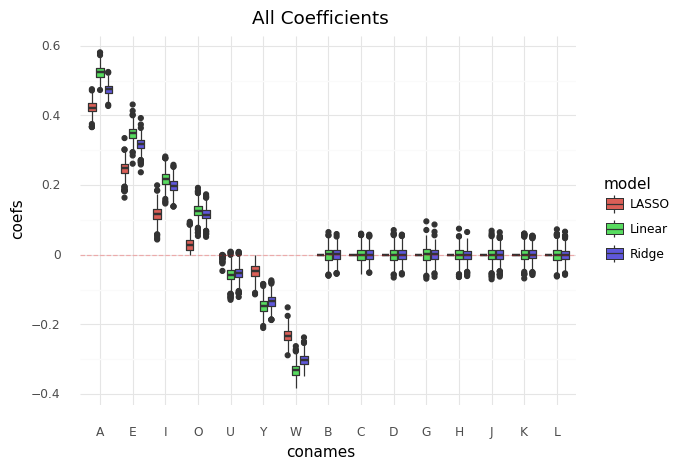

<ggplot: (8778225895491)>

In [28]:
#put the coefficents in order
sim["conames"] = pd.Categorical(sim["conames"], categories=["A", "E", "I", "O", "U", "Y", "W",
                                              "B","C","D","G","H","J","K","L", "M","N"])

    
# all coefficients
(ggplot(sim, aes(x = "conames",
                y = "coefs",
                fill = "model")) +
  geom_boxplot() + ggtitle("All Coefficients") + theme_minimal() +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red", alpha = 0.25 ))



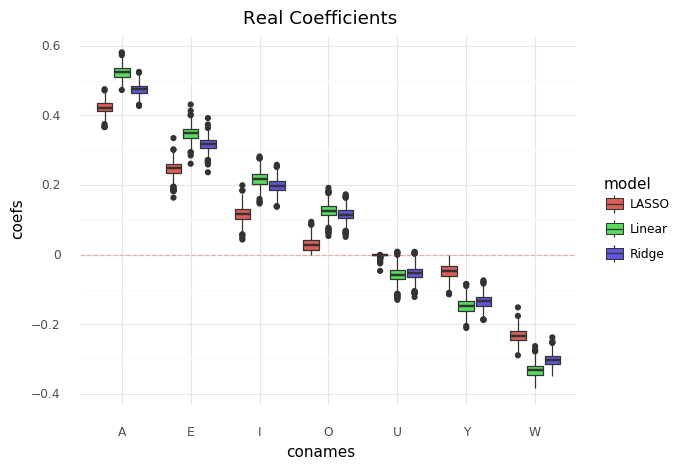

<ggplot: (8778229059738)>

In [29]:
#just vowels (these are the variables that DO have relationships with X)
(ggplot(sim.loc[sim['conames'].isin(["A", "E", "I", "O", "U", "Y", "W"]),]
, aes(x = "conames",
      y = "coefs",
      fill = "model")) +
  geom_boxplot() + ggtitle("Real Coefficients") + theme_minimal() +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red", alpha = 0.25 ))
      

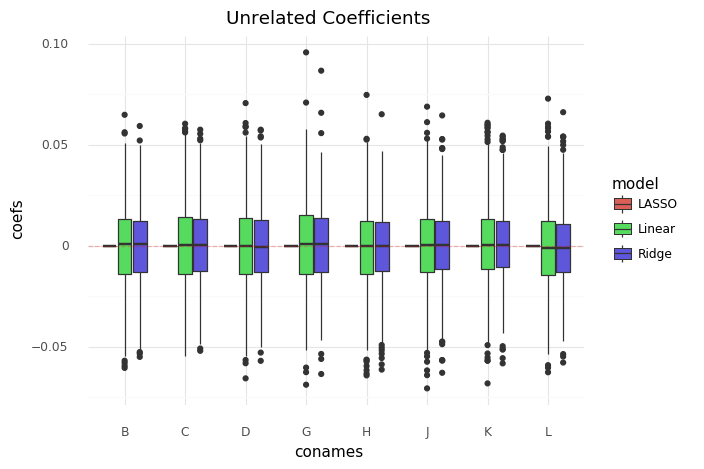

<ggplot: (8778229581550)>

In [30]:
#just consonants (these are the variables that DO NOT have relationships with X)

(ggplot(sim.loc[sim['conames'].isin(["B","C","D","G","H","J","K","L", "M","N"]),],
        aes(x = "conames",
        y = "coefs",
        fill = "model")) +
  geom_boxplot() + ggtitle("Unrelated Coefficients") + theme_minimal() +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red", alpha = 0.25 ))

### *Question*

Compare the ranges (using the boxplots generated above) of coefficients when using Linear Regression (unpenalized), LASSO (L1 penalty), and Ridge (L2 penalty). What patterns do you see in the coefficients that *do* have relationships with X (vowels)? What patterns do you see in the coefficients that *do not* have relationships with X (consonants)?

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" width = 200px />

### *Question*

What do you think will happen if you increase `alpha`, which controls how much we penalize large coefficients? Try it out below:

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" width = 200px />

In [ ]:
n = 1000 #number of samples per model
nsims = 1000 # number of simulations
alpha = ??? # how harshly we penalize


# running the simulation
sim = compare(n = n, alpha = alpha)

for i in range(1,nsims):
    sim = sim.append(compare(n = n, alpha = alpha), ignore_index = True)

    
    
#put the coefficents in order
sim["conames"] = pd.Categorical(sim["conames"], categories=["A", "E", "I", "O", "U", "Y", "W",
                                              "B","C","D","G","H","J","K","L"])

    
# all coefficients
(ggplot(sim, aes(x = "conames",
                y = "coefs",
                fill = "model")) +
  geom_boxplot() + ggtitle("All Coefficients") + theme_minimal() +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red", alpha = 0.25 ))



### *Question*

What do you think will happen if you decrease `alpha`, which controls how much we penalize large coefficients? Try it out below (you can set `alpha` to be very small, but for computational reasons, don't set it to be exactly zero):

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" width = 200px />

In [ ]:
n = 1000 #number of samples per model
nsims = 1000 # number of simulations
alpha =  # how harshly we penalize


# running the simulation
sim = compare(n = n, alpha = alpha)

for i in range(1,nsims):
    sim = sim.append(compare(n = n, alpha = alpha), ignore_index = True)

    
    
#put the coefficents in order
sim["conames"] = pd.Categorical(sim["conames"], categories=["A", "E", "I", "O", "U", "Y", "W",
                                              "B","C","D","G","H","J","K","L"])

    
# all coefficients
(ggplot(sim, aes(x = "conames",
                y = "coefs",
                fill = "model")) +
  geom_boxplot() + ggtitle("All Coefficients") + theme_minimal() +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red", alpha = 0.25 ))



# 2. Building your own Regularized Models

Back when we learned Logistic Regression, I briefly mentioned that in sklearn, `LogisticRegression()` does regularization by default. Now you know what that really means!

Using the Beyonce data below, use dancebility, energy, speechiness, acousticness, instrumentalness, duration_ms, and liveness to predict mode. 

Build one model with NO penalty, and one with a LASSO (L1) penalty. See [documentaion](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) if you need a refresher on how to change the `penalty` argument.


How do the coefficients compare between the two models?

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" width = 200px />

In [ ]:
bey = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/Beyonce_data.csv")



# 3. Taking a Look at Regularization and Overfitting

In lecture (and hopefully in class), we've talked about the fact that regularization helps prevent overfitting. The datasets X1, X2, X3, and X4 are all (fake; **already z-scored**) samples from the **same** population. Fit a regular linear regression model on dataset X1, and then see how well it performs (in terms of MSE) on X2, X3, and X4. Essentiall, you're treating X1 as the train set, and X2, X3, and X4 as the test set.

Then fit a Ridge model on X1, and then see how well it performs (in terms of MSE) on X2, X3, and X4. Make sure you're aware of when the numbers are in scientific notation. 


Which (Linear or Ridge) is higher on X1? What about on X2, X3, and X4? What does that indicate?

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" width = 200px />

In [ ]:
X1 = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/regX1.csv")
X2 = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/regX2.csv")
X3 = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/regX3.csv")
X4 = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/regX4.csv")


predictors = ["X" + str(i) for i in range(1,100)]

X1.shape



In [ ]:
l1 = LinearRegression()
r1 = Ridge(alpha = 750)

l1.fit(X1[predictors], X1["outcome"])
r1.fit(X1[predictors], X1["outcome"])

In [ ]:
# CALCULATE ALL THE MSE's below:

### YOUR CODE HERE ###

# MSEs for X1
lin1 = # linear regression
rid1 = # ridge regression

print("linear mse is : ", lin1)
print("ridge mse is  : ", rid1)

# MSEs for X2
lin2 = # linear regression
rid2 = # ridge regression

print("linear mse is : ", lin2)
print("ridge mse is  : ", rid2)

# MSEs for X3
lin3 = # linear regression
rid3 = # ridge regression

print("linear mse is : ", lin3)
print("ridge mse is  : ", rid3)

# MSEs for X4
lin4 = # linear regression
rid4 = # ridge regression

print("linear mse is : ", lin4)
print("ridge mse is  : ", rid4)

plotdf = pd.DataFrame({"MSE": [lin1, lin2, lin3, lin4, rid1, rid2, rid3, rid4],
                     "dataset": [1,2,3,4,1,2,3,4],
                     "model": ["LR", "LR", "LR", "LR", "RR", "RR","RR", "RR"]})

ggplot(plotdf, aes(x = "dataset", y = "MSE", color = "model")) + geom_line() + geom_point() + theme_minimal()